# Optical Flow:  RAFT 


In [6]:
import cv2 as cv
import torch
import time
import warnings
import numpy as np

from torchvision.models.optical_flow import raft_large, raft_small
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.utils import flow_to_image
from ultralytics import YOLO

import matplotlib.pyplot as plt
from savedata import SaveData

## 1. Seguimiento de la mano con YOLO y RAFT

In [27]:
def get_hand(img, model, person_idx=3):
    detections = model(img)
    keypoints = detections[0].keypoints
    keypoint_coordinates = keypoints[person_idx].xy[0]
    right_wrists = keypoint_coordinates[10]
    return int(right_wrists[0]), int(right_wrists[1])

In [9]:
def preprocess(batch):
    # Preprocesamiento para RAFT: conviertes a float32, normalizas y cambias tamaño
    transforms = T.Compose([
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=0.5, std=0.5), # De [0,1] a [-1,1]
        T.Resize(size=(520, 960)),      # Ajusta a dimensiones requeridas (ejemplo)
    ])
    return transforms(batch)

In [10]:
warnings.filterwarnings("ignore")

video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()
if not status:
    raise RuntimeError("No se pudo leer el video.")

size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/result_raft.mp4', fourcc, 20.0, size) 

video_out.write(old_frame)

# Cargar el modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')

# Obtener la posición inicial de la mano
hand_point = get_hand(old_frame, model)

device = "cuda" if torch.cuda.is_available() else "cpu"
old_tensor = preprocess(F.to_tensor(old_frame).unsqueeze(0)).to(device)

# Cargar RAFT
raft_model = raft_large(pretrained=True, progress=False).to(device)
raft_model.eval()

scale_x = 960 / size[0]  # ancho
scale_y = 520 / size[1]  # alto

tracking_path = [hand_point]  # Lista para almacenar la trayectoria de la mano
tracking_path_skips = [hand_point]  # Lista para almacenar la trayectoria de la mano con saltos
i = 0
frames = [i]

compute_start = time.time()

while True:
    status, frame = video.read()
    if not status:
        break

    new_tensor = preprocess(F.to_tensor(frame).unsqueeze(0)).to(device)

    with torch.no_grad():
        flow_list = raft_model(old_tensor, new_tensor)
    predicted_flow = flow_list[-1]

    flow_img = flow_to_image(predicted_flow)
    flow_img = flow_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    flow_img = (flow_img * 255).astype(np.uint8)

    x_scaled = int(hand_point[0] * scale_x)
    y_scaled = int(hand_point[1] * scale_y)

    x_scaled = max(0, min(flow_img.shape[1]-1, x_scaled))
    y_scaled = max(0, min(flow_img.shape[0]-1, y_scaled))

    flow_x = predicted_flow[0, 0, y_scaled, x_scaled].item()
    flow_y = predicted_flow[0, 1, y_scaled, x_scaled].item()

    new_hand_x = hand_point[0] + (flow_x / scale_x)
    new_hand_y = hand_point[1] + (flow_y / scale_y)
    hand_point = (int(new_hand_x), int(new_hand_y))

    # Guardar posición actual en la trayectoria
    tracking_path.append(hand_point)
    tracking_path_skips.append(hand_point)

    i += 1
    frames.append(i)

    # Dibujar el punto de la mano con el color del flujo
    hand_color = flow_img[y_scaled, x_scaled].tolist()  # BGR
    cv.circle(frame, hand_point, 5, hand_color, -1)

    # Dibujar la trayectoria hasta el momento
    # Para dibujar la ruta, convertimos los puntos a un arreglo NumPy de ints
    if len(tracking_path) > 1:
        pts = np.array(tracking_path, dtype=np.int32)
        cv.polylines(frame, [pts], False, (0, 255, 0), 2)

    cv.imshow('RAFT-Mano', frame)
    video_out.write(frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

    video_out.write(frame)
    old_frame = frame
    old_tensor = new_tensor

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 721.8ms
Speed: 7.7ms preprocess, 721.8ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 1791.3379211425781 seconds
Time spent: 29.855632019042968 minutes


In [12]:
x_coordinates = [point[0] for point in tracking_path]
y_coordinates = [point[1] for point in tracking_path]
time = [i for i in range(len(tracking_path))]
x_coordinates_skips = [point[0] for point in tracking_path_skips]
y_coordinates_skips = [point[1] for point in tracking_path_skips]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

data = {
    "x_coordinates": x_coordinates,
    "y_coordinates": y_coordinates,
    "x_skip": x_coordinates_skips,
    "y_skip": y_coordinates_skips,
    "time": y_coordinates_skips,
    "time_frame": frames,
    "speed": speed.tolist(),
    "time_spent": spent_time
}

savedata = SaveData(data, "tracking_raft_large")
savedata.save_data()

Datos guardados en ../resultados\tracking_raft_large.txt


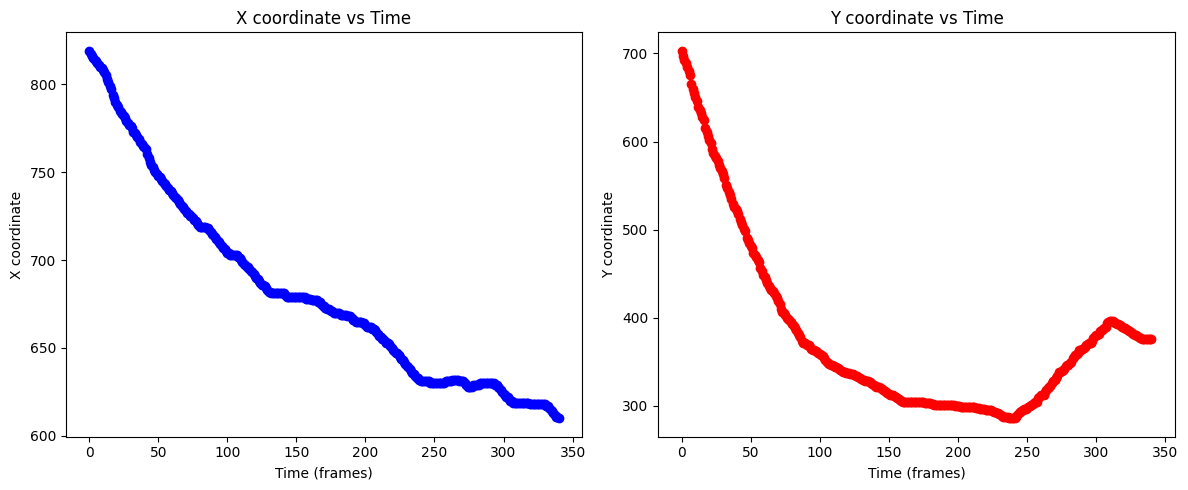

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(frames, x_coordinates_skips, label="x(t)", color="blue", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("X coordinate")
plt.title("X coordinate vs Time")

plt.subplot(1, 2, 2)
plt.plot(frames,y_coordinates_skips, label="y(t)", color="red", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("Y coordinate")
plt.title("Y coordinate vs Time")

plt.tight_layout()
plt.show()

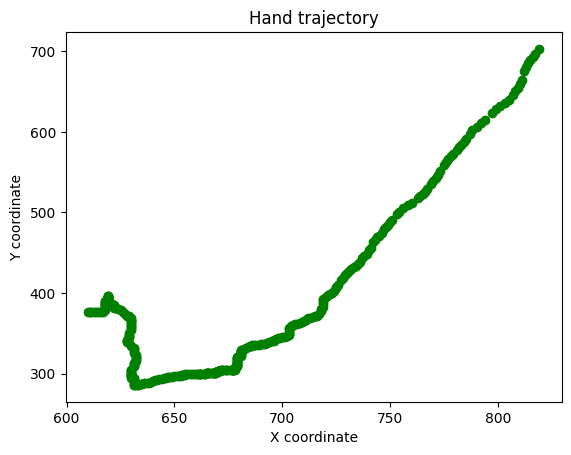

In [14]:
plt.plot(x_coordinates_skips, y_coordinates_skips, label="Hand trajectory", color="green", marker='o', linestyle='')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Hand trajectory")
plt.show()

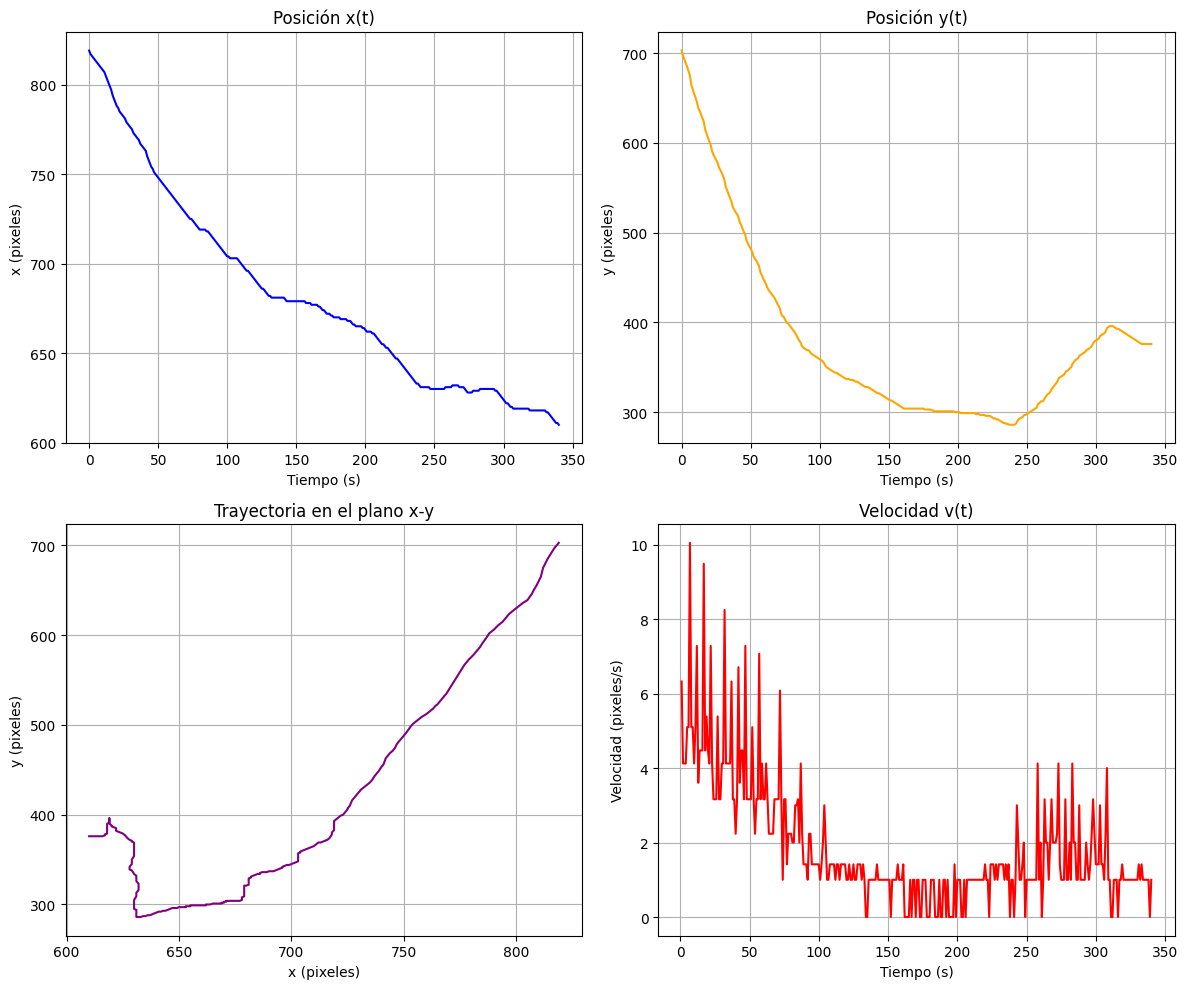

In [15]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()

### 1.1 Seguimiento de la mano con YOLO y RAFT small

In [ ]:
import time

In [19]:
warnings.filterwarnings("ignore")

video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()
if not status:
    raise RuntimeError("No se pudo leer el video.")

size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/result_raft_small.mp4', fourcc, 20.0, size) 

video_out.write(old_frame)

# Cargar el modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')

# Obtener la posición inicial de la mano
hand_point = get_hand(old_frame, model)

device = "cuda" if torch.cuda.is_available() else "cpu"
old_tensor = preprocess(F.to_tensor(old_frame).unsqueeze(0)).to(device)

# Cargar RAFT
raft_model = raft_small(pretrained=True, progress=False).to(device)
raft_model.eval()

scale_x = 960 / size[0]  # ancho
scale_y = 520 / size[1]  # alto

tracking_path = [hand_point]  # Lista para almacenar la trayectoria de la mano
tracking_path_skips = [hand_point]  # Lista para almacenar la trayectoria de la mano con saltos
i = 0
frames = [i]

compute_start = time.time()

while True:
    status, frame = video.read()
    if not status:
        break

    new_tensor = preprocess(F.to_tensor(frame).unsqueeze(0)).to(device)

    with torch.no_grad():
        flow_list = raft_model(old_tensor, new_tensor)
    predicted_flow = flow_list[-1]

    flow_img = flow_to_image(predicted_flow)
    flow_img = flow_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    flow_img = (flow_img * 255).astype(np.uint8)

    x_scaled = int(hand_point[0] * scale_x)
    y_scaled = int(hand_point[1] * scale_y)

    x_scaled = max(0, min(flow_img.shape[1]-1, x_scaled))
    y_scaled = max(0, min(flow_img.shape[0]-1, y_scaled))

    flow_x = predicted_flow[0, 0, y_scaled, x_scaled].item()
    flow_y = predicted_flow[0, 1, y_scaled, x_scaled].item()

    new_hand_x = hand_point[0] + (flow_x / scale_x)
    new_hand_y = hand_point[1] + (flow_y / scale_y)
    hand_point = (int(new_hand_x), int(new_hand_y))

    # Guardar posición actual en la trayectoria
    tracking_path.append(hand_point)
    tracking_path_skips.append(hand_point)

    i += 1
    frames.append(i)

    # Dibujar el punto de la mano con el color del flujo
    hand_color = flow_img[y_scaled, x_scaled].tolist()  # BGR
    cv.circle(frame, hand_point, 5, hand_color, -1)

    # Dibujar la trayectoria hasta el momento
    # Para dibujar la ruta, convertimos los puntos a un arreglo NumPy de ints
    if len(tracking_path) > 1:
        pts = np.array(tracking_path, dtype=np.int32)
        cv.polylines(frame, [pts], False, (0, 255, 0), 2)

    cv.imshow('RAFT-Mano', frame)
    video_out.write(frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

    video_out.write(frame)
    old_frame = frame
    old_tensor = new_tensor

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 674.5ms
Speed: 0.0ms preprocess, 674.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


In [20]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 572.1392266750336 seconds
Time spent: 9.535653777917226 minutes


In [21]:
x_coordinates = [point[0] for point in tracking_path]
y_coordinates = [point[1] for point in tracking_path]
time = [i for i in range(len(tracking_path))]
x_coordinates_skips = [point[0] for point in tracking_path_skips]
y_coordinates_skips = [point[1] for point in tracking_path_skips]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

data = {
    "x_coordinates": x_coordinates,
    "y_coordinates": y_coordinates,
    "x_skip": x_coordinates_skips,
    "y_skip": y_coordinates_skips,
    "time": y_coordinates_skips,
    "time_frame": frames,
    "speed": speed.tolist(),
    "time_spent": spent_time
}

savedata = SaveData(data, "tracking_raft_small")
savedata.save_data()

Datos guardados en ../resultados\tracking_raft_small.txt


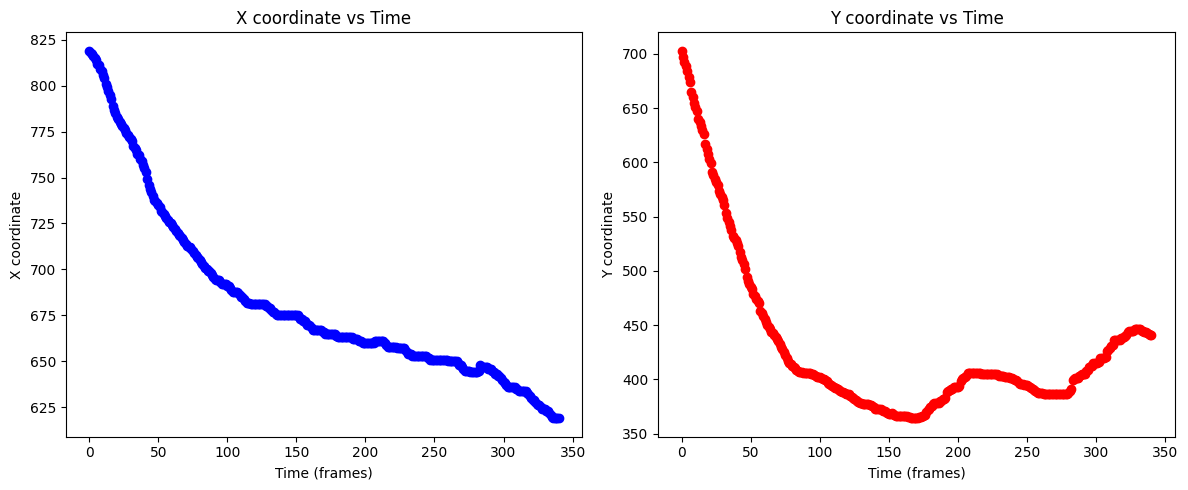

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(frames, x_coordinates_skips, label="x(t)", color="blue", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("X coordinate")
plt.title("X coordinate vs Time")

plt.subplot(1, 2, 2)
plt.plot(frames,y_coordinates_skips, label="y(t)", color="red", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("Y coordinate")
plt.title("Y coordinate vs Time")

plt.tight_layout()
plt.show()

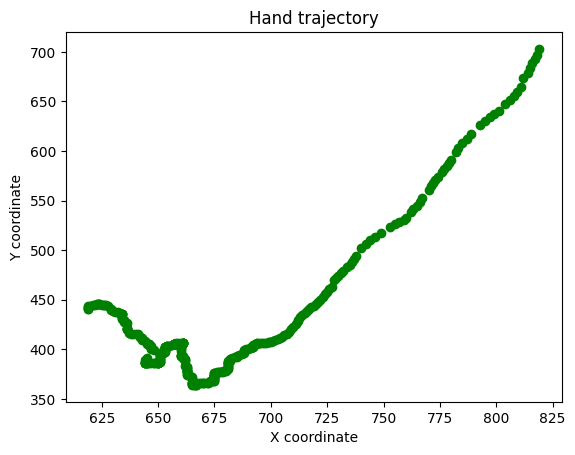

In [23]:
plt.plot(x_coordinates_skips, y_coordinates_skips, label="Hand trajectory", color="green", marker='o', linestyle='')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Hand trajectory")
plt.show()

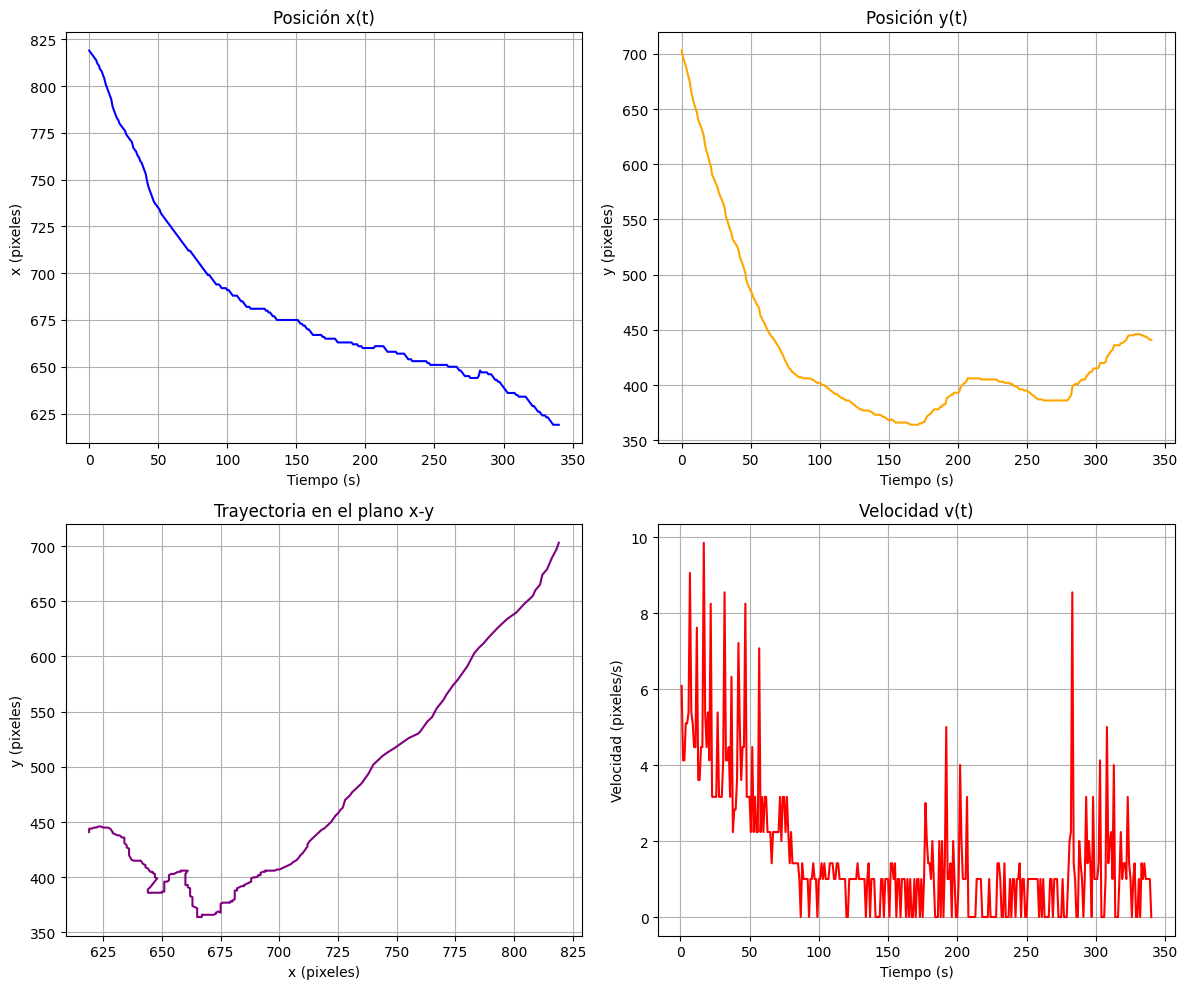

In [24]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()

## 2. Flujo óptico

### 2.1. Flujo óptico con Raft Large

In [1]:
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()

size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/result_optical_flow_raft.mp4', fourcc, 20.0, size)

# Convertir el primer cuadro a tensores
old_frame_tensor = F.to_tensor(old_frame).unsqueeze(0).to(device)

while True:
    status, frame = video.read()
    if not status:
        break

    # Convertir el cuadro actual a tensores
    frame_tensor = F.to_tensor(frame).unsqueeze(0).to(device)

    # Calcular el flujo óptico con RAFT
    with torch.no_grad():
        list_of_flows = model(old_frame_tensor, frame_tensor)
        predicted_flow = list_of_flows[-1]

    # Convertir el flujo a imagen
    flow_img = flow_to_image(predicted_flow)

    # Convertir el flujo a formato OpenCV
    flow_img_np = (flow_img.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    # Mostrar el flujo óptico
    cv.imshow("Flujo Óptico RAFT", flow_img_np)
    video_out.write(flow_img_np)

    # Actualizar el cuadro anterior
    old_frame_tensor = frame_tensor

    if cv.waitKey(1) & 0xFF == 27:  # Presiona ESC para salir
        break

video.release()
video_out.release()
cv.destroyAllWindows()

c:\Users\Susana\anaconda3\envs\piav\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Susana\anaconda3\envs\piav\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


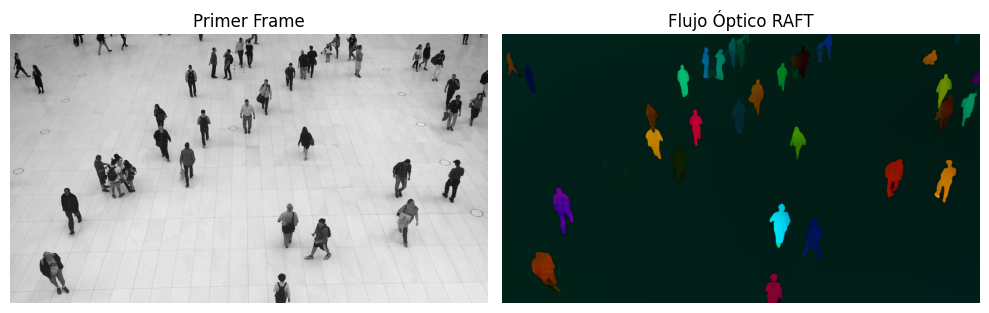

In [7]:
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

cap = cv.VideoCapture("../videos/people2.mp4")

frame_indices = [50, 200]
frames = []

for i in range(max(frame_indices) + 1):
    ret, frame = cap.read()
    if i in frame_indices:
        frames.append(frame)
    if not ret:
        print(f"No se pudo leer el frame {i}.")
        cap.release()
        exit()

cap.release()

# Convertir a tensores
frame_0_tensor = F.to_tensor(frames[0]).unsqueeze(0).to(device)
frame_1_tensor = F.to_tensor(frames[1]).unsqueeze(0).to(device)

# Calcular el flujo óptico con RAFT
with torch.no_grad():
    list_of_flows = model(frame_0_tensor, frame_1_tensor)
    predicted_flow = list_of_flows[-1]

# Convertir el flujo a imagen
flow_img = flow_to_image(predicted_flow)

# Convertir el flujo a formato NumPy
flow_img_np = (flow_img.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

# Convertir los frames originales a RGB para matplotlib
frame_0_rgb = cv.cvtColor(frames[0], cv.COLOR_BGR2RGB)
flow_img_rgb = cv.cvtColor(flow_img_np, cv.COLOR_BGR2RGB)

# Graficar con matplotlib
plt.figure(figsize=(10, 5))

# Primer frame
plt.subplot(1, 2, 1)
plt.imshow(frame_0_rgb)
plt.title("Primer Frame")
plt.axis("off")

# Resultado del flujo óptico RAFT
plt.subplot(1, 2, 2)
plt.imshow(flow_img_rgb)
plt.title("Flujo Óptico RAFT")
plt.axis("off")

plt.tight_layout()
plt.show()

### 2.2. Flujo óptico con Raft Small

In [4]:
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = raft_small(pretrained=True, progress=False).to(device)
model = model.eval()

video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()

size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/result_optical_flow_raft_small.mp4', fourcc, 20.0, size)

# Convertir el primer cuadro a tensores
old_frame_tensor = F.to_tensor(old_frame).unsqueeze(0).to(device)

while True:
    status, frame = video.read()
    if not status:
        break

    # Convertir el cuadro actual a tensores
    frame_tensor = F.to_tensor(frame).unsqueeze(0).to(device)

    # Calcular el flujo óptico con RAFT
    with torch.no_grad():
        list_of_flows = model(old_frame_tensor, frame_tensor)
        predicted_flow = list_of_flows[-1]

    # Convertir el flujo a imagen
    flow_img = flow_to_image(predicted_flow)

    # Convertir el flujo a formato OpenCV
    flow_img_np = (flow_img.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    cv.imshow("Flujo Óptico RAFT", flow_img_np)
    video_out.write(flow_img_np)

    old_frame_tensor = frame_tensor

    if cv.waitKey(1) & 0xFF == 27:
        break

video.release()
video_out.release()
cv.destroyAllWindows()

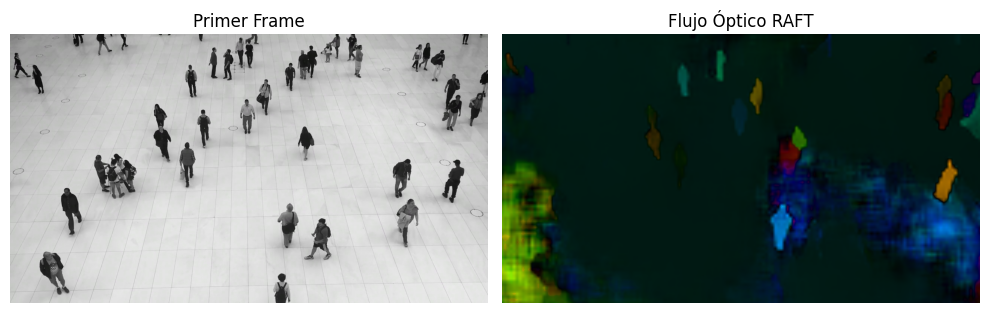

In [8]:
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = raft_small(pretrained=True, progress=False).to(device)
model = model.eval()

cap = cv.VideoCapture("../videos/people2.mp4")

frame_indices = [50, 200]
frames = []

for i in range(max(frame_indices) + 1):
    ret, frame = cap.read()
    if i in frame_indices:
        frames.append(frame)
    if not ret:
        print(f"No se pudo leer el frame {i}.")
        cap.release()
        exit()

cap.release()

# Convertir a tensores
frame_0_tensor = F.to_tensor(frames[0]).unsqueeze(0).to(device)
frame_1_tensor = F.to_tensor(frames[1]).unsqueeze(0).to(device)

# Calcular el flujo óptico con RAFT
with torch.no_grad():
    list_of_flows = model(frame_0_tensor, frame_1_tensor)
    predicted_flow = list_of_flows[-1]

# Convertir el flujo a imagen
flow_img = flow_to_image(predicted_flow)

# Convertir el flujo a formato NumPy
flow_img_np = (flow_img.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

# Convertir los frames originales a RGB para matplotlib
frame_0_rgb = cv.cvtColor(frames[0], cv.COLOR_BGR2RGB)
flow_img_rgb = cv.cvtColor(flow_img_np, cv.COLOR_BGR2RGB)

# Graficar con matplotlib
plt.figure(figsize=(10, 5))

# Primer frame
plt.subplot(1, 2, 1)
plt.imshow(frame_0_rgb)
plt.title("Primer Frame")
plt.axis("off")

# Resultado del flujo óptico RAFT
plt.subplot(1, 2, 2)
plt.imshow(flow_img_rgb)
plt.title("Flujo Óptico RAFT")
plt.axis("off")

plt.tight_layout()
plt.show()